### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import feature
from skimage import exposure
from skimage.filters import unsharp_mask
from keras.applications import VGG16
import cv2
import os

2024-07-16 17:47:01.449534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Select Preprocessing Options

In [54]:
# Convert the images from rgb to single channel grayscale
grayscale_flg = 1

# Perform histogram equalization
histogram_eq_flg = 1

# Scale pixel values from between 0-1 to 0-255
scaling_flg = 1

# Resize the image to the provided dimensions
resize_flg = 1
resize_shape = (256, 256)

# Sharpen image using unsharp masking with provided Gaussian filter
unsharp_mask_flg = 1
unsharp_radius = 2
unsharp_amount = 1

### Load Images

In [3]:
def load_image(image_path):
    return plt.imread(file_path)

### Convert Images to Grayscale

In [4]:
def rgb2gray(image):
    return np.mean(image, axis=2)

### Scale Pixel Values between 0 and 255

In [55]:
def scale(image):
    return image * 255

### Resize Images

In [6]:
def resize(image, size):
    return cv2.resize(image, size)

### Histogram Equalization

In [7]:
def histEqual(image):
    return cv2.equalizeHist(image)

### Unsharp Masking

In [8]:
def unsharp(image, radius, amount):
    return unsharp_mask(image, radius, amount)

### Preprocess Images

In [56]:
root_dir = './data/Bone Break Classification'

# Initialize dictionary to store images
images = {}

# Iterates through the different bone fracture folders
for folder in os.listdir(root_dir):

    folder_path = os.path.join(root_dir, folder)
    images[folder] = {}

    # Iterates through the test and train folders for each bone fracture type
    for subfolder in os.listdir(folder_path):

        if subfolder.startswith('.'):
            continue
            
        subfolder_path = os.path.join(folder_path, subfolder)
        images[folder][subfolder] = []

        # Iterates through images in folder
        for file in os.listdir(subfolder_path):

            if file.endswith('.jpg'):

                file_path = os.path.join(subfolder_path, file)
                
                img = load_image(file_path)
                
                if grayscale_flg:
                    img = rgb2gray(img)
                    
                if histogram_eq_flg:
                    img = histEqual(np.array(img, dtype=np.uint8))

                if resize_flg:
                    img = resize(img, resize_shape)

                if unsharp_mask_flg:
                    img = unsharp_mask(img, unsharp_radius, unsharp_amount)

                if scaling_flg:
                    img = scale(img)
                
                images[folder][subfolder].append(img)


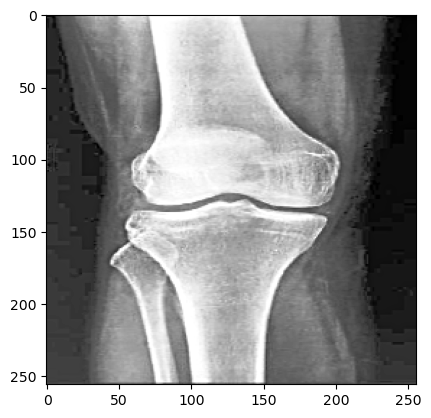

In [57]:
plt.imshow(images['Avulsion fracture']['Train'][10], cmap='gray')

### Feature Extraction

### Edge Detection

In [45]:
def get_edges(image, lower_thresh, upper_thresh, apeture):
    return cv2.Canny(image, lower_thresh, upper_thresh, apeture)

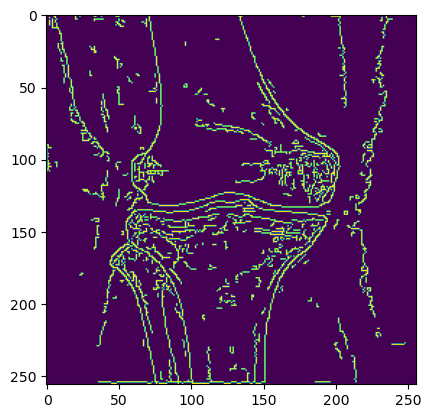

In [58]:
img_int = np.array(images['Avulsion fracture']['Train'][10], dtype=np.uint8)
edges = get_edges(img_int, 100, 150, 5)
plt.imshow(edges)
pass

### HOG

In [59]:
def get_hog(image):
    fd, hog_image = feature.hog(image=image, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=True)

    return hog_image

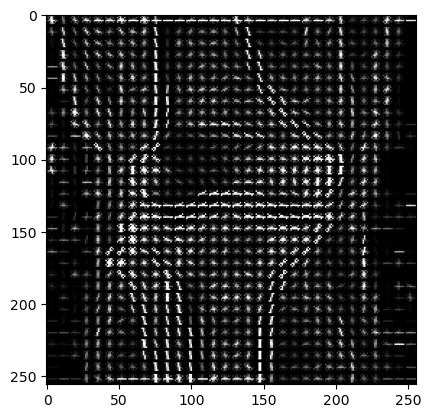

In [60]:
hog_image = get_hog(images['Avulsion fracture']['Train'][10])
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap='gray')
pass

### Histogram of Intensities

In [63]:
def get_hoi(image):
    data = plt.hist(image.ravel(), bins=256, range=[0, 255])
    return data

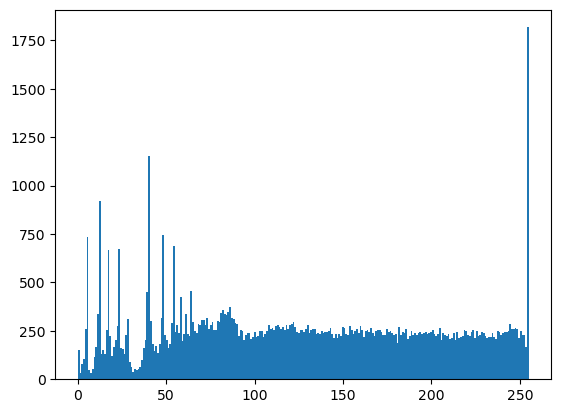

In [64]:
data = get_hoi(images['Avulsion fracture']['Train'][10])

### Local Binary Pattern

In [65]:
def get_lbp(image):
    radius = 3
    return feature.local_binary_pattern(image, 5*radius, radius)

/opt/anaconda3/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


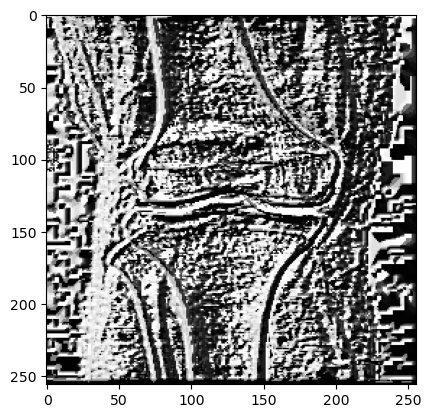

In [66]:
plt.imshow(get_lbp(images['Avulsion fracture']['Train'][10]), cmap='gray')

### VGG16 Features

In [5]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import skimage

img = images['Avulsion fracture']['Train'][10]
img = skimage.color.gray2rgb(img)

features = model.predict(img.reshape((1, 256, 256, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


In [26]:
features.shape

(1, 8, 8, 512)